# Sparse FBA

In [1]:
from cobra.io import load_model
import numpy as np

model = load_model("textbook")
len(model.metabolites), len(model.reactions)

(72, 95)


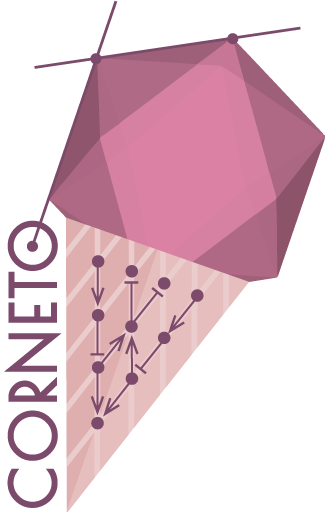

In [2]:
import corneto as cn
cn.info()

## Manual implementation of sparse FBA

In [3]:
from corneto.methods.metabolism.fba import fba_problem

G = cn.Graph.from_cobra_model(model)
P = fba_problem(G)
P.expr

{'_flow': Variable((95,), _flow), 'flow': Variable((95,), _flow)}

In [4]:
rid = list(G.get_edges_by_attr("id", "Biomass_Ecoli_core"))[0]
biomass = P.expr.flow[rid]
P.add_objectives(biomass, weights=-1)
P.solve()
print(biomass.value)

0.8739215069684303


In [5]:
# Add custom constraints to the problem
P += biomass <= 0.5
P.solve(solver="SCIPY")
biomass.value

0.5

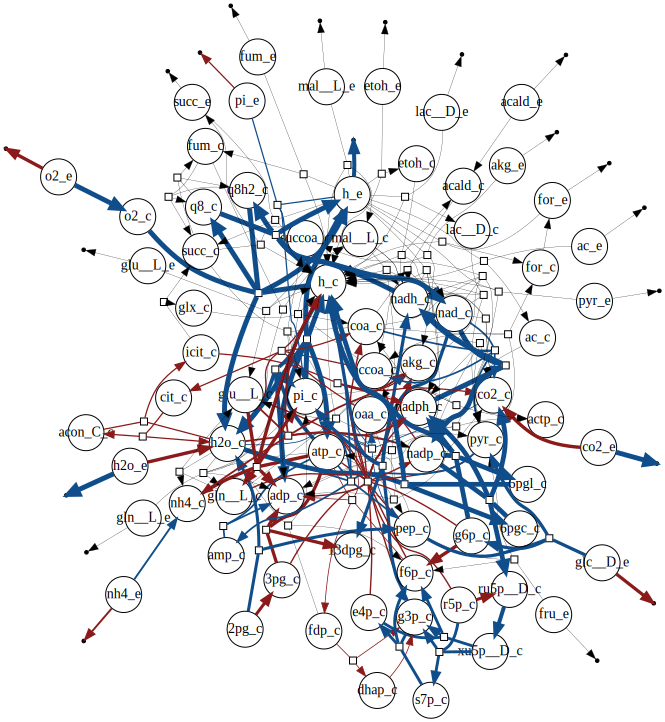

In [6]:
G.plot(custom_edge_attr=cn.pl.flow_style(P), layout="fdp")

Now we are going to see how to use specialized building blocks from CORNETO to automatically add indicators for the presence of reactions in a model. Indicators are binary variables associated to a continuous variable: when the indicator is 0, the continuous variable is 0; and when the indicator is 1, the continuous variable is unconstrained. 

By creating indicators for flow, we can try for example to minimize the number of reactions with flux in the model, by minimizing the total number of ones in the indicator vector.

In [7]:
from corneto.backend._base import Indicator
# Automatically create a new indicator variable for the flow
# If the indicator is 0, the flow is blocked, if it is 1, the flow is unblocked (can take any value within bounds, including 0)
P += Indicator("unblocked_flow")
P.expr

{'_flow': Variable((95,), _flow),
 'unblocked_flow': Variable((95,), unblocked_flow, boolean=True),
 'flow': Variable((95,), _flow)}

In [8]:
# We try to minimize the number of 1s (i.e., maximize reactions with blocked flux)
P.add_objectives(sum(P.expr.unblocked_flow))
P.solve()
print(biomass.value)

0.0


In [9]:
# How many reactions are unblocked?
sum(P.expr.unblocked_flow.value)

16.0

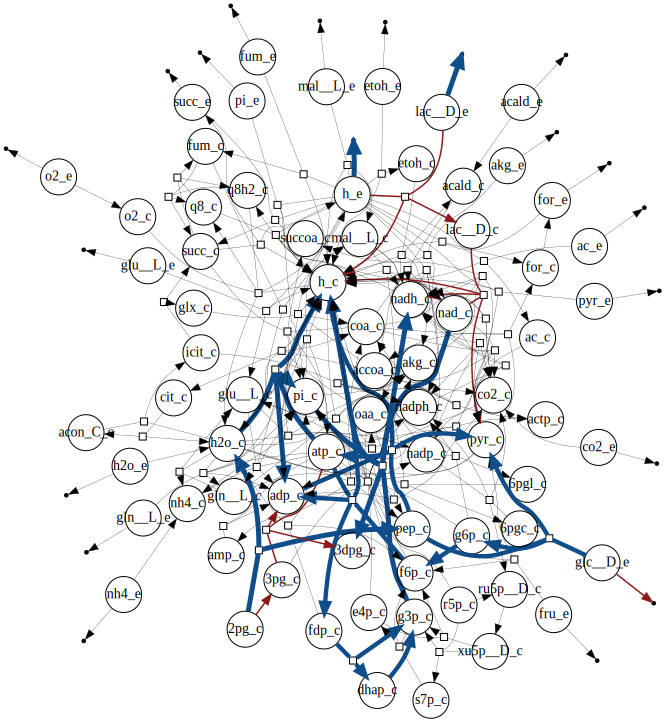

In [10]:
G.plot(custom_edge_attr=cn.pl.flow_style(P), layout="fdp")

## Sparse FBA with min. flux

In [11]:
P = fba_problem(G)
P += P.expr.flow[rid] >= 0.2
P += Indicator("unblocked_flow")
P.add_objectives(sum(P.expr.unblocked_flow))
P.solve(solver="SCIPY")

Problem(Minimize(Expression(AFFINE, NONNEGATIVE, ())), [Inequality(Constant(CONSTANT, UNKNOWN, (95,))), Inequality(Variable((95,), _flow)), Equality(Expression(AFFINE, UNKNOWN, (72,)), Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Expression(AFFINE, UNKNOWN, (95,))), Inequality(Variable((95,), _flow))])

In [12]:
sum(P.expr.unblocked_flow.value)

42.0

In [13]:
sum(abs(P.expr.flow.value) >= 1e-6)

42